## Project Overview

I made some predictions about how much bike rental traffic there will be in different areas of Chicago.

While there typically isn't too much traffic at individual stations, the influx and outflux of bikes to different service regions can have important logistic and business implications. Monitoring or, even better, predicting the movement of bikes around the city is useful!

This notebook mirrors the README but includes the associated code.

### Data Source

The Chicago Divvy bike share [data](https://divvy-tripdata.s3.amazonaws.com/index.html)
- 13 columns, ~2 million rows (1/2 year)

## The Data
Let's take a peek at what the raw data looks like. A sample has been included below.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data_clean import *
from rnn_model import *

In [2]:
# This sample is just ten rows of raw data
pd.read_csv('data_sample.csv')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,CFA86D4455AA1030,classic_bike,2021-03-16 08:32:30,2021-03-16 08:36:34,Humboldt Blvd & Armitage Ave,15651,Stave St & Armitage Ave,13266,41.917513,-87.701809,41.917741,-87.691392,casual
1,30D9DC61227D1AF3,classic_bike,2021-03-28 01:26:28,2021-03-28 01:36:55,Humboldt Blvd & Armitage Ave,15651,Central Park Ave & Bloomingdale Ave,18017,41.917513,-87.701809,41.914166,-87.716755,casual
2,846D87A15682A284,classic_bike,2021-03-11 21:17:29,2021-03-11 21:33:53,Shields Ave & 28th Pl,15443,Halsted St & 35th St,TA1308000043,41.842733,-87.635491,41.830661,-87.647172,casual
3,994D05AA75A168F2,classic_bike,2021-03-11 13:26:42,2021-03-11 13:55:41,Winthrop Ave & Lawrence Ave,TA1308000021,Broadway & Sheridan Rd,13323,41.968812,-87.657659,41.952833,-87.649993,casual
4,DF7464FBE92D8308,classic_bike,2021-03-21 09:09:37,2021-03-21 09:27:33,Glenwood Ave & Touhy Ave,525,Chicago Ave & Sheridan Rd,E008,42.012701,-87.666058,42.050491,-87.677821,casual
5,CEBA8516FD17F8D8,classic_bike,2021-03-20 11:08:47,2021-03-20 11:29:39,Glenwood Ave & Touhy Ave,525,Chicago Ave & Sheridan Rd,E008,42.012701,-87.666058,42.050491,-87.677821,casual
6,297268586B79588B,classic_bike,2021-03-20 14:10:41,2021-03-20 14:22:13,State St & Kinzie St,13050,Lake Shore Dr & North Blvd,LF-005,41.889187,-87.627754,41.911722,-87.626804,member
7,F39301858B6077DD,electric_bike,2021-03-23 07:56:51,2021-03-23 08:05:50,Shore Dr & 55th St,TA1308000009,Ellis Ave & 60th St,KA1503000014,41.795230,-87.580828,41.785218,-87.601083,member
8,D297F199D875BABE,electric_bike,2021-03-31 15:31:19,2021-03-31 15:35:58,Clinton St & Lake St,13021,Franklin St & Jackson Blvd,TA1305000025,41.885552,-87.641727,41.877287,-87.636155,member
9,36B877141175ED7E,classic_bike,2021-03-11 17:37:37,2021-03-11 17:52:44,Michigan Ave & Lake St,TA1305000011,Racine Ave & Washington Blvd,654,41.886024,-87.624117,41.883073,-87.656952,member


This data looks pretty rich and there's a lot of directions you could go with it. In fact here's a [project](https://github.com/nick-kopy/Modeling-Electric-Rental-Bike-Lock-Ups) that explores whether or not people park their electric bikes back at a station. But for now we're interested start and end stations and where traffic is moving. 

Let's take a look at a single station in more detail. The busiest station in Chicago in the past year was located at Streeter Dr & Grand Ave.

In [3]:
sdga = station_data('Streeter Dr & Grand Ave', eda=True)

As a simple visualization, let's look at how much traffic there was at this one station on the last three days of our data set. Below are March 29-31st, a Monday to Wednesday, where you can see traffic peaked in the afternoon but was much lower on Wednesday.

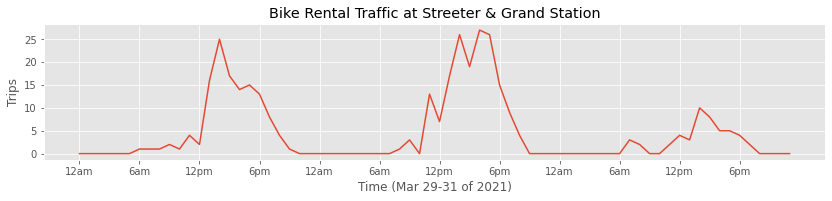

In [4]:
fig, ax = plt.subplots(figsize=(14,2.5))

ax.plot(np.arange(72), sdga['target'].iloc[-72:])
ax.set_xticks([0,6,12,18,24,30,36,42,48,54,60,66])
ax.set_xticklabels(['12am','6am','12pm','6pm','12am','6am','12pm','6pm','12am','6am','12pm','6pm'])
ax.set_xlabel('Time (Mar 29-31 of 2021)')
ax.set_ylabel('Trips')
ax.set_title('Bike Rental Traffic at Streeter & Grand Station');

Next we'll look at how all of the downtown stations looked, with the Streeter and Grand station included. The graph below is almost the same but instead of all traffic, this one is broken down into riders entering downtown and riders leaving downtown. Trips that began and ended within downtown are not included.

In [5]:
dt_s = station_data('downtown', start_end='start', exclude_within_region=True)
dt_e = station_data('downtown', start_end='end', exclude_within_region=True)

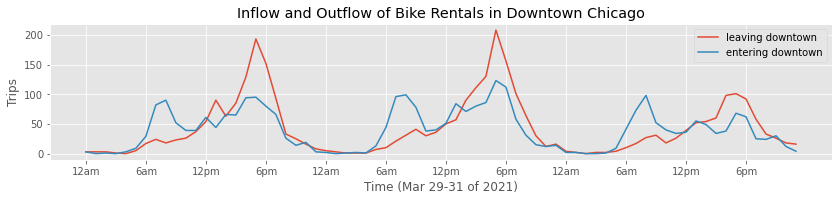

In [6]:
fig, ax = plt.subplots(figsize=(14,2.5))

ax.plot(np.arange(72), dt_s['target'].iloc[-72:], label='leaving downtown')
ax.plot(np.arange(72), dt_e['target'].iloc[-72:], label='entering downtown')
ax.set_xticks([0,6,12,18,24,30,36,42,48,54,60,66])
ax.set_xticklabels(['12am','6am','12pm','6pm','12am','6am','12pm','6pm','12am','6am','12pm','6pm'])
ax.set_title('Inflow and Outflow of Bike Rentals in Downtown Chicago')
ax.set_xlabel('Time (Mar 29-31 of 2021)')
ax.set_ylabel('Trips')
ax.legend();

We can see some pretty regular trends: a 9am spike, a bit of activity for lunch, and then a 5pm spike. This is pretty likely to be commuters and if you were to look at some weekend data it's a bit more spread out.

Interestingly about the same amount of riders come into downtown at the beginning and end of the day, but riders leaving downtown are pretty concentrated in the evening.

And in fact you can compare bikes coming in and out not just on the hour, but over time. Over the past six months there's been 6,000 more rides going out than coming in (18,000 in the past year). If bikes are not transported back, they would quickly disappear from downtown.

In [7]:
# How many more bikes are leaving downtown than coming in?
(dt_s.sum() - dt_e.sum())[0]

6168.0

So it's not hard to see how the flow of bikes between areas is an important logistical problem. Getting ahead of the curve before stations start running out of bikes can be the difference between losing loyal customers and keeping commuters happy.

## Predicting Traffic
The first thing to do when making a predictive model like this is to establish a baseline, the simplest reasonable guess. You test this baseline and your model's prediction against the true data, and ideally your model does better. How much better can be a metric for measuring your model's performance.

My baseline is just that for any given hour the amount of bikes entering and leaving an area will be the same as the previous hour. For a six hour prediction, baseline will be the average traffic of the last six hours. Each prediction will have a unique baseline to compare against, but they will all hover around the average for our data.

In [8]:
print('Average bikes entering downtown per hour: {}'.format(int(dt_s.mean()[0])))
print('Average bikes leaving downtown per hour: {}'.format(int(dt_e.mean()[0])))

Average bikes entering downtown per hour: 15
Average bikes leaving downtown per hour: 14


We can certainly build a better model than this though. There are plenty of options for making predictions. Another simple prediction is to just guess that traffic will look the same as the day before, hour for hour. The problem here is that traffic isn't only dependent on time, but changes day to day. An ARIMA model is a popular choice that takes into account general trends (many bikeshare programs are expanding!) but has a difficult time with more than one trend pattern at play (known as multi-seasonality). Traffic depends not only on time, but day of the week, month, holidays, etc. which are totally on their own timelines and are therefor difficult to capture with ARIMA and time series analysis.

Recurrent neural networks are models that can be trained on several months of data and but also have a short term memory that takes into account the most recent information when making predictions. LSTMs (long short term memory) and GRUs (gated recurrent unit) are improved versions that make the most of the memory they have. 

Unlike other machine learning models, neural networks can be made up of any number of layers or nodes. When you add dropout layers, activation gates, memory cells, and such other framework pieces, the architecture alone can make different models wholy unique. And this is before training!

Finding the right achitecture is an iterative process. You tweak and test until you end up with a model that suits your needs. Below is some of the iterations I went through and how they performed. The evaluation score was RMSE as compared to a baseline for a 6 hour prediction (ie 1 - RMSE prediction / RMSE baseline). Epochs were run 50 at a time until performance got worse instead of better.

These models though are tuned specifically to the dataset used (inbound traffic to Lincoln Park) and pays specific attention to RMSE on a 6 hour window. If we looked at a different region or optimized for a 24 hour window instead of 6 hours we may end up settling on a different architecture. Which window you optimize for is dependent on your use case. Whether you want to optimize each region separately or find one architecture that generalizes to all regions is a similar decision. Improving models even a few percentage points can have important payoffs for a company, but at the same time it may not be worth it given the time cost. As with many decisions, it depends.

|Model type         |Nodes    |Memory window|Dropout|Epochs |RMSE-6 |Baseline|Performance|RMSE-24|
|-------------------|---------|-------------|-------|-------|-------|--------|-----------|-------|
|LSTM               |24       |24 hours     |0      |100    |0.077  |0.058   |-33%       |0.082  |
|LSTM               |24       |24 hours     |0.3    |50     |0.027  |0.058   |53%        |0.030  |
|GRU                |24       |24 hours     |0.3    |50     |0.040  |0.058   |31%        |0.081  |
|LSTM               |100      |120 (5 days) |0.3    |50     |0.089  |0.146   |39%        |0.144  |
|GRU                |100      |120 (5 days) |0.3    |100    |0.072  |0.146   |51%        |0.112  |
|GRU (2 layers)     |100 x 50 |120 (5 days) |0.3    |150    |0.059  |0.146   |60%        |0.123  |

>To make your own adjustments, feel free to fork and clone this repo. Then find the model structure in model_funcs.py and create your own model!


In [ ]:
# Model that learns from rides leaving downtown, predicts how many will leave in the future
gru_downtown_out = Model(dt_e)

In [ ]:
# Train the model. 
# Training 2 or 3 times can improve model performance but will eventually get worse as the model overfits.
gru_downtown_out.train()

Let's load up a GRU model that can predict what traffic will look like in the next few hours.

In [ ]:
# Save the model to use later
gru_downtown_out.model.save('models/my_model')

In [9]:
# We can also load up models we saved before
old_model = tf.keras.models.load_model('models/downtown_in')
gru_downtown_in = Model(df=dt_e, load_model=old_model)

These models were all trained on data from October 2020 until March 2021. There is a model for each of six regions around Chicago but let's stick with downtown because it's the most active and most interesting. During this training the model learning how to take a look at a five day window in the past and predict up to five days into the future. Let's make a simple prediction.

Below the model looks at March 25-29 and makes a prediction for March 30th. In this case it doesn't do a bad job, and improves significantly over the baseline of just guessing the baseline.

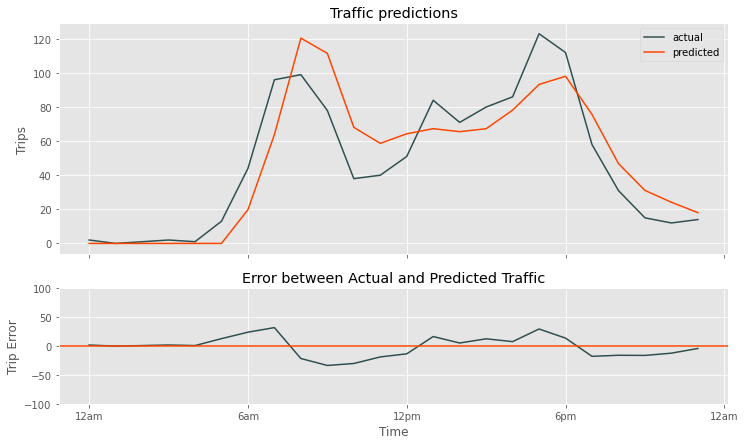

In [10]:
gru_downtown_in.predict_plot(n_out=24, offset=72)

In [9]:
# These prediction scores use RMSE
# Here the baseline is calculated as the average traffic of the previous 24 hours
yhat, ybase = gru_downtown_in.predict_score(n_out=24, offset=72)

print('This model did {}% better than baseline'.format(round((1-yhat/ybase)*100, 2)))

This model did 60.7% better than baseline


This model is not immune to some of the difficulties other models face. For example if we look at five weekdays and then predict a Saturday, the model does a good job of repeating what it remembers but faces an unexpected reality.

Below is a prediction of March 27th, a Saturday, looking at March 22-26, a Monday to Friday. Turns out people don't ride the same way on Saturdays.

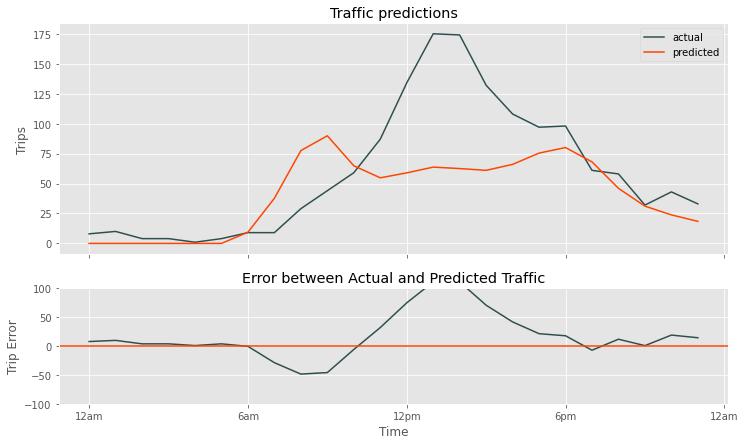

In [10]:
gru_downtown_in.predict_plot(n_out=24, offset=0)

In [11]:
# Score of the above graph
yhat, ybase = gru_downtown_in.predict_score(n_out=24, offset=0)

print('This model did {}% better than baseline'.format(round((1-yhat/ybase)*100, 2)))

This model did 26.92% better than baseline


If you are curious about pushing this model past its limits, here is a prediction across five days (Mar 27-31). Even though it gets the general shape (the trend) pretty close, after too long the prediction is out of sync. The repeating patterns in the error tell us that the model is no longer representing the data well.

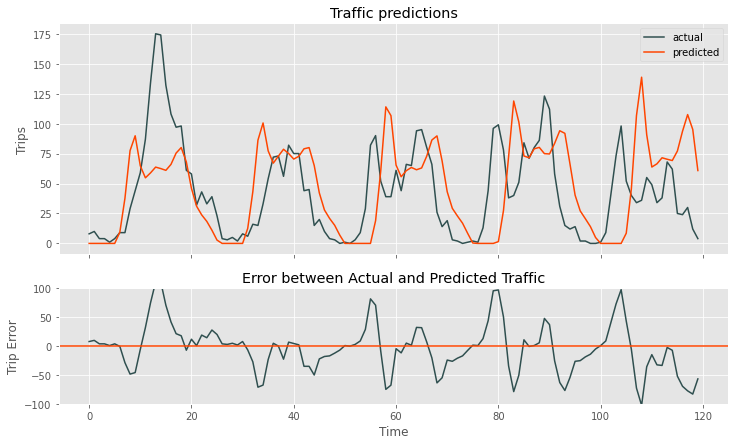

In [30]:
gru_downtown_in.predict_plot(n_out=120, offset=0)

It is possible to make a model that looks back farther than five days. More data and more analysis would certainly make a more powerful prediction, but as they say in the math and data science world: there's no free lunch. A longer memory will require more complicated neural network architecture to capture trends and that will in turn require much more processing power.

But for our purposes this model is enough. It doesn't require an inordinate amount of time to train and can look decently enough six to twelve hours into the future.

Here's a hypothetical use case:

In [14]:
# Grabbing the "traffic out" downtown model
old_model = tf.keras.models.load_model('models/downtown_out')
gru_downtown_out = Model(df=dt_s, load_model=old_model)

In [19]:
# Making 12 hour predictions from both traffic in and traffic out models
# 6am-6pm inclusive is actually 13 hours so we add one more, just for visuals
pred_in = gru_downtown_in.predict(n_out=13, offset=54)
pred_in = gru_downtown_in.scaler.inverse_transform(pred_in.reshape(-1, 1))

pred_out = gru_downtown_out.predict(n_out=13, offset=54)
pred_out = gru_downtown_out.scaler.inverse_transform(pred_out.reshape(-1, 1))

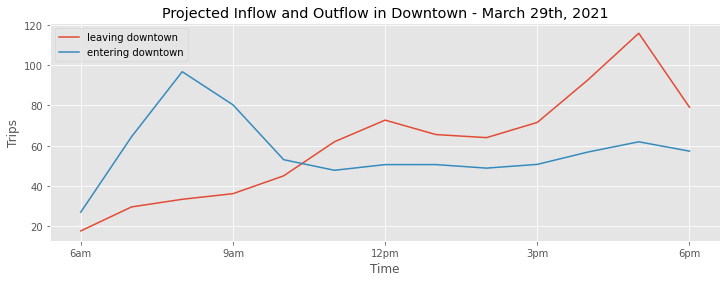

In [34]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(13), pred_out, label='leaving downtown')
ax.plot(np.arange(13), pred_in, label='entering downtown')
ax.set_xticks([0,3,6,9,12])
ax.set_xticklabels(['6am','9am','12pm','3pm','6pm'])
ax.set_title('Projected Inflow and Outflow in Downtown - March 29th, 2021')
ax.set_xlabel('Time')
ax.set_ylabel('Trips')
ax.legend();

This graph has no pre-existing data, it is purely projections into the future. It looks at the past to figure out what traffic in and traffic out will look like for downtown on specifically Monday March 29th from 6am to 6pm. With data collected over the previous five days, it could be run automatically in less than a minute and sent to somebody's dashboard. Training could be done once a month or so to keep the AI up to date. 

With a little more domain knowledge this becomes pretty useful. The average 8am in-bound spike over the previous 6 months was about 80 rides, meaning this morning might be busy. The average 5pm out-bound spike was almost 150, meaning this evening might be slow.

If you look at the error on these projections they typically do well in the first six hours and start to vary more past that. It's no problem though, we could simply add the latest numbers in and make a new prediction at noon to get an updated projection! And why stop there? We don't need to retrain the model for new predictions, so we could have a rolling prediction that updates every hour!

## Conclusion
Rental bikes have been around for several years now and have a pretty regular customer base by now. There are observable trends in ridership that move up and down across the day, the week, or the year, meaning that by looking at the past you can get a decent idea of how many people will be riding bikes in the future. Artificial intelligence takes past observations and makes future predictions which can be specific and measured for accuracy.

We built a recurrent neural network that looks at the past five days and makes a pretty decent prediction of the future six hours. This can have some great logistical applications, telling you what parts of town bikes need to be moved to (and this is important) before stations start running out. If you load up the app, you can see in real time how many bikes are left at any given station. But if you rely on this information alone you're reacting instead of anticipating. There won't be enough bikes and that translates to definite lost revenue and lost customers.

### Future work
Our model did decent, but could definitely be improved upon.
- Dataset included many more features would could be used to make a "multi-variate" model with more numbers to crunch when making predictions.
- Hourly weather data could be included as a feature in a multi-variate model
- The weather forecast could be an incredible piece to help make predictions

### Assumptions

- The past year has been something of an anomaly with the pandemic and all. Can we draw meaningful conclusions from all this that wouldn't just fade away as vaccines roll out and business returns to normal? The numbers [seem to say](https://github.com/nick-kopy/Exploration-of-bike-share-programs-post-pandemic) that even though Chicago's bikeshare program did take a hit initially, it bounced back pretty quick. So assuming that these conclusions and predictions are still relevant despite COVID seems to be a safe assumptions.
- Station groupings are loosely based on [this map](https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-All-Map/bk89-9dk7) by on the Chicago Data Portal. These are not official groupings of any kind and are actually not restricted to their labels. What I mean is that some Wicker Park stations are actually in West Town but Wicker Park was just an easy name to go with for that "block" on the map. These models would really benefit (and be more applicable to the business) with relevant and sensical groupings.